In [1]:
### Pulse analysis, spectrum
# Integral, OFL (can move around) , OF -> energy estimators
# OFL_chi2 (pick corresponding chi2) -> 2D plot
# Peak finding and source calibration -> energy linearity
# Baseline noise into energy, energy threshold -> use calibrated peak amplitude. 
# Energy resolution at calibration energy -> fit calibration peak.

# Optimal Filter catergories
# OFO: No delay
# OF: Time delay allowed in full trace (for me this is likely +/- 8k samples, but check)
# OFL: Time delay allowed is set by config.OFL_DELAY setting

In [2]:
import os
# We want to be in the scratch directory.
try:
    if "scratch" not in os.getcwd():
        os.chdir('./scratch')  
except:
    print("Check current directory", os.getcwd())

In [26]:
# Imports
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic
import datetime

import RQ_helper

In [4]:
# Constants 
#results_fn = "/project/def-zqhong/RicochetData/MIT/MIT_Al_December2022/processed/OFResults_Fe55_20230204.joblib" #_20230111
#output_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_December2022/output/"
#series = "Fe55"

globus_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/"
series = "AmBe_August"
results_fn = f"OFResults_{series}"+".joblib"
output_dir = globus_dir+"output/"

In [5]:
# Load reduced quantities
RQ_data = joblib.load(globus_dir+"processed/"+results_fn)
exec(RQ_data["config_str"])
#Prepare RQ_helper
rq_helper = RQ_helper.RQ_helper(RQ_data, config, series, output_dir)
#list(RQ_data.keys())

RQ helper is initialised


In [6]:
# Define new fields:

#Time since previous pulse, define for all triggers (not noise traces)
trace_len = config.real_trace_length
trig_loc_tr = RQ_data["trig_loc"]
num_traces_file = max(RQ_data["trig_traceidx"]+1)
trace_loc = RQ_data["trig_traceidx"]
file_loc = RQ_data["trig_fileidx"]
num_files = max(RQ_data["trig_fileidx"]+1)

trig_loc_total = (file_loc*num_traces_file+trace_loc)*trace_len+trig_loc_tr
time_diffs_trig = np.diff(trig_loc_total[RQ_data["trig_ch"]==1])/config.Fs
time_diffs_trig = np.insert(time_diffs_trig, 0, trig_loc_tr[0])
time_diffs_noise = np.diff(trig_loc_total[RQ_data["trig_ch"]==0])/config.Fs
time_diffs_noise = np.insert(time_diffs_noise, 0, trig_loc_tr[0])

RQ_data["time_diff_prev_trig"] = np.empty_like(RQ_data['trig_ch'], dtype=float)
RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"]==1] = time_diffs_trig
RQ_data["time_diff_prev_trig"][RQ_data["trig_ch"]==0] = time_diffs_noise
RQ_data["trig_loc_total"] = trig_loc_total

# Maximum value of the tail, baseline subtracted
RQ_data["MaxTailRel_CH1"] = RQ_data["MaxTail_CH1"]-RQ_data["MeanBase_CH1"] 
RQ_data["TailAmpFraction_CH1"] = RQ_data["MaxTailRel_CH1"]/RQ_data["Amplitude_CH1"]
RQ_data["TailIntFraction_CH1"] = RQ_data["IntegralTail_CH1"]/RQ_data["Integral_CH1"]

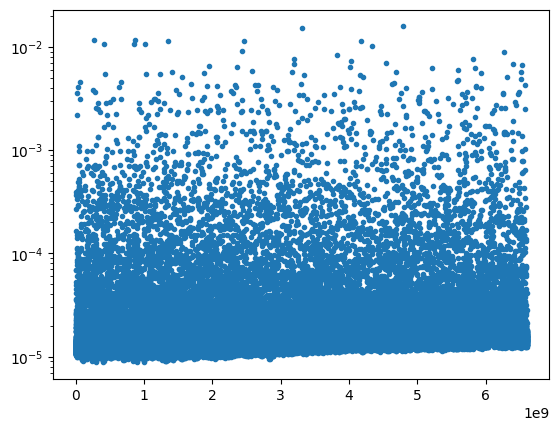

In [7]:
# Look at the baseline variance for stability.
plt.plot(RQ_data["trig_loc_total"], RQ_data['BaselineVariance_CH1'], marker='.', lw=0)
plt.yscale("log")
#plt.ylim(1e-6, 5e-6)

In [8]:
# Quality cuts:
# OFL_time_ between 0,0.005 (5milliseconds)
# Time since last trigger should be at least 0.1s
# The maximum amplitude should be in the first part of the post-trig samples and not in the second.

mask_trig_quality = (RQ_data['trig_ch']==1) &\
                    (RQ_data["TailAmpFraction_CH1"]<0.99) &\
                    (RQ_data["time_diff_prev_trig"]>0.1) &\
                    (RQ_data["TailAmpFraction_CH1"]<0.99) &\
                    (RQ_data['OFL_time_CH1']>0) & (RQ_data['OFL_time_CH1']<0.005)

if "Fe55" in series:
    # Baseline slope needs to be within [-1e7,1e7]
    # BaselineVariance_ < 3.5e-6    -> double peaked! compare with total trig number.
    # Additional weak cut on the trig_amp threshold.
    mask_trig_quality =  mask_trig_quality &\
                        (RQ_data['BaselineVariance_CH1']<3.5e-6) &\
                        (np.abs(RQ_data['BaselineSlope_CH1'])<1e-7) &\
                        (RQ_data["trig_amp"]>1.5)
    
elif "August" in series:
    mask_trig_quality =  mask_trig_quality &\
                         (RQ_data['BaselineVariance_CH1']<2e-5) &\
                         (np.abs(RQ_data['BaselineSlope_CH1'])<4e-7)

In [9]:
# Define Masks
mask_noise = (RQ_data['trig_ch']==0)
mask_tes = (RQ_data['trig_ch']==1) & (RQ_data['Amplitude_CH1']/RQ_data['Integral_CH1']>0.003) & (RQ_data['Amplitude_CH1']>0.02)
mask_crystal = mask_trig_quality & (~mask_tes)
mask_noisy = ~mask_noise & ~mask_trig_quality & ~mask_tes

RQ_data["mask_crystal"] = mask_crystal
RQ_data["mask_tes"] = mask_tes

print('Original triggered events:', sum(RQ_data['trig_ch']))
print('After quality cuts:', sum(mask_trig_quality))
print('TES-like pulses:', sum(mask_tes))
print('Crystal-like pulses', sum(mask_crystal))
print("The auto threshold was tes to", RQ_data['trig_config']['CH1']['trigger_threshold_auto'], "which was calculated to be", RQ_data['trig_config']['CH1']['trigger_threshold'])

Original triggered events: 142080
After quality cuts: 104792
TES-like pulses: 1227
Crystal-like pulses 104784
The auto threshold was tes to None which was calculated to be 4


### Explore 1D Data with histograms

In [10]:
trig_mask = RQ_data['trig_ch']
make_hist = False

for k,v in RQ_data.items(): 
    if type(v)==str or type(v)==dict or len(v)!=len(trig_mask):
        print(k,v)
    elif np.issubdtype(v.dtype, np.number):        
        # Make a histogram
        triggered = v[trig_mask==1]
        random = v[trig_mask==0]
        print("Noise:  {:<30}#items:".format(k), random.shape,", mean: {:<10.3g}, std: {:<10.3g}".format(np.mean(random),np.std(random)))
        print("Trigger:{:<30}#items:".format(k), triggered.shape,", mean: {:<10.3g}, std: {:<10.3g}".format(np.mean(triggered),np.std(triggered)))

        if make_hist:
            range_min = max(min(v), np.median(v)-np.std(v))
            range_max = np.percentile(v, 90)
            if all(np.isfinite((range_min,range_max))):
                ranges = (range_min,range_max)
            else:
                renges=None
                
            plt.hist([triggered,random], range=ranges, bins=100, 
                    stacked=False, label=['triggered', 'random'],
                    histtype="stepfilled", alpha=0.6)
            plt.xlabel(k)
            plt.ylabel("# Triggered events")
            plt.legend()
            plt.show()
    else:
        print("error")
        

Noise:  OF0_CH1                       #items: (22000,) , mean: -2.74e-05 , std: 0.00427   
Trigger:OF0_CH1                       #items: (142080,) , mean: 0.0119    , std: 0.019     
Noise:  OF0_chi2_CH1                  #items: (22000,) , mean: 1.37      , std: 1.93      
Trigger:OF0_chi2_CH1                  #items: (142080,) , mean: 1.83      , std: 3.96      
Noise:  OF0_chi2time_CH1              #items: (22000,) , mean: 3.43      , std: 17.9      
Trigger:OF0_chi2time_CH1              #items: (142080,) , mean: 6.3       , std: 31.4      
Noise:  OF0_chi2timeFiltered_CH1      #items: (22000,) , mean: 2.45      , std: 17.8      
Trigger:OF0_chi2timeFiltered_CH1      #items: (142080,) , mean: 5.25      , std: 31.2      
Noise:  OF0_chi2timeShort_CH1         #items: (22000,) , mean: 0.331     , std: 25.8      
Trigger:OF0_chi2timeShort_CH1         #items: (142080,) , mean: 1.71      , std: 34.6      
Noise:  OF_CH1                        #items: (22000,) , mean: 0.00865   , std: 0.022

### Explore 2D data 

In [11]:
# Define 2D configs
config_2d_scatter = {"type":"scatter"}
config_2d_hist = {"type":"hist"}

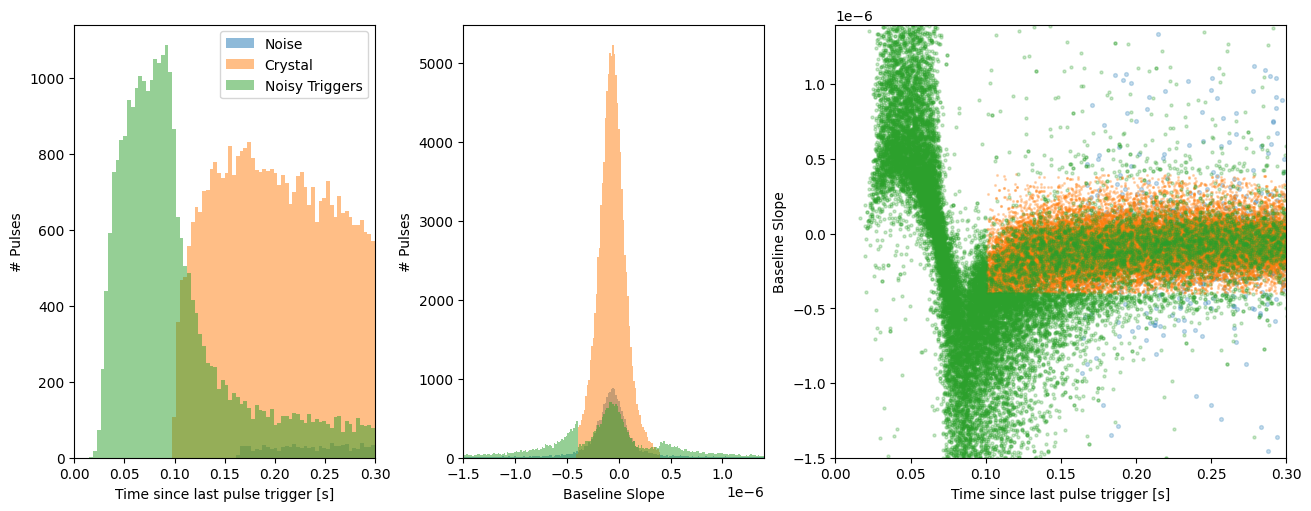

In [12]:
# Investigate pilup pulse cut
var1 = {'name': 'time_diff_prev_trig',
        'label': 'Time since last pulse trigger [s]',
        'range': (0,0.3),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineSlope_CH1',
        'label': 'Baseline Slope',
        'range': (-1.5e-6,1.4e-6),
        'bins': 200,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_noisy] 
mask_labs = ['Noise', 'Crystal', 'Noisy Triggers']
fix,ax = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

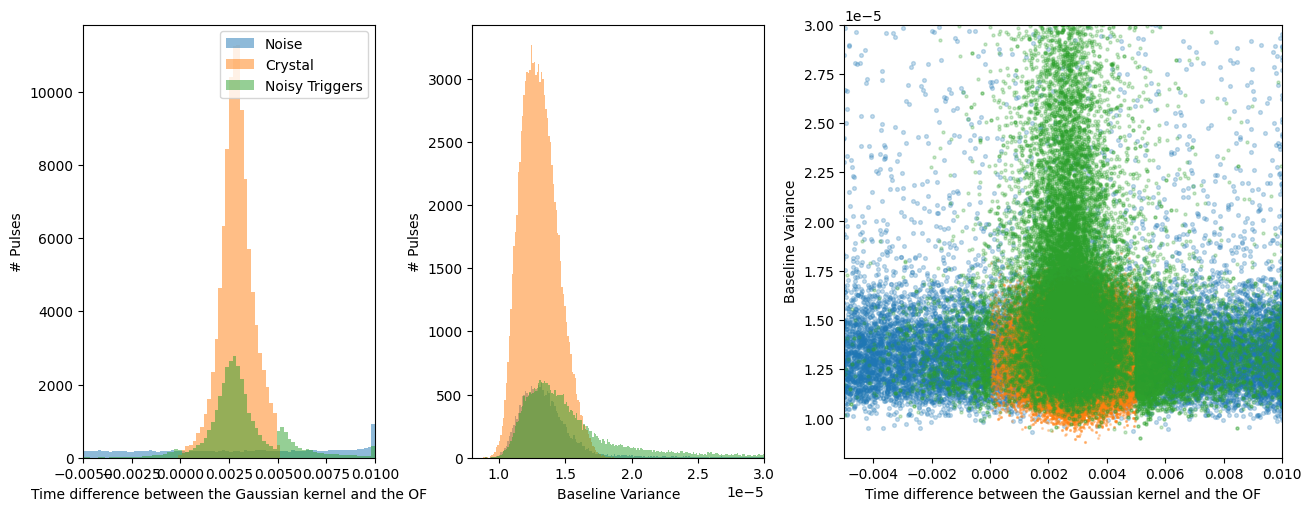

In [13]:
# Investigate pilup pulse cut
var1 = {'name': 'OFL_time_CH1',
        'label': 'Time difference between the Gaussian kernel and the OF',
        'range': (-0.005,0.01),
        'bins': 80,
        'norm':False
       }

var2 = {'name': 'BaselineVariance_CH1',
        'label': 'Baseline Variance',
        'range': (8e-6,3e-5),
        'bins': 200,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_noisy] 
mask_labs = ['Noise', 'Crystal', 'Noisy Triggers']
fix,ax = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

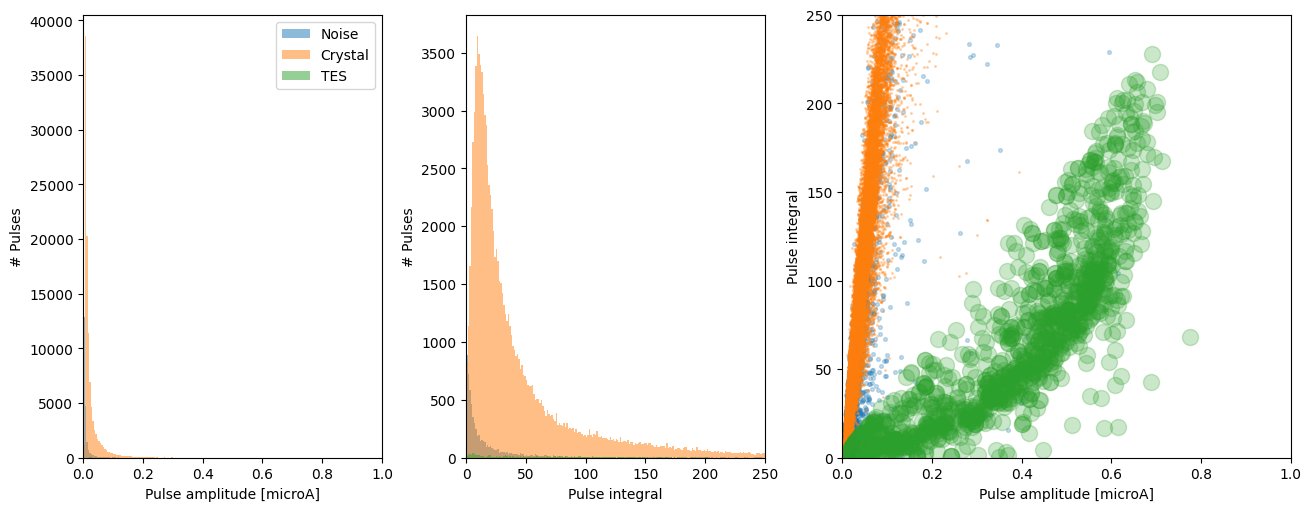

In [14]:
# Zoom out
var1 = {'name': 'Amplitude_CH1',
        'label': 'Pulse amplitude [microA]',
        'range': (0.00,1),
        'bins': 200,
        'norm':False
       }

var2 = {'name': 'Integral_CH1',
        'label': 'Pulse integral',
        'range': (0,250),
        'bins': 200,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

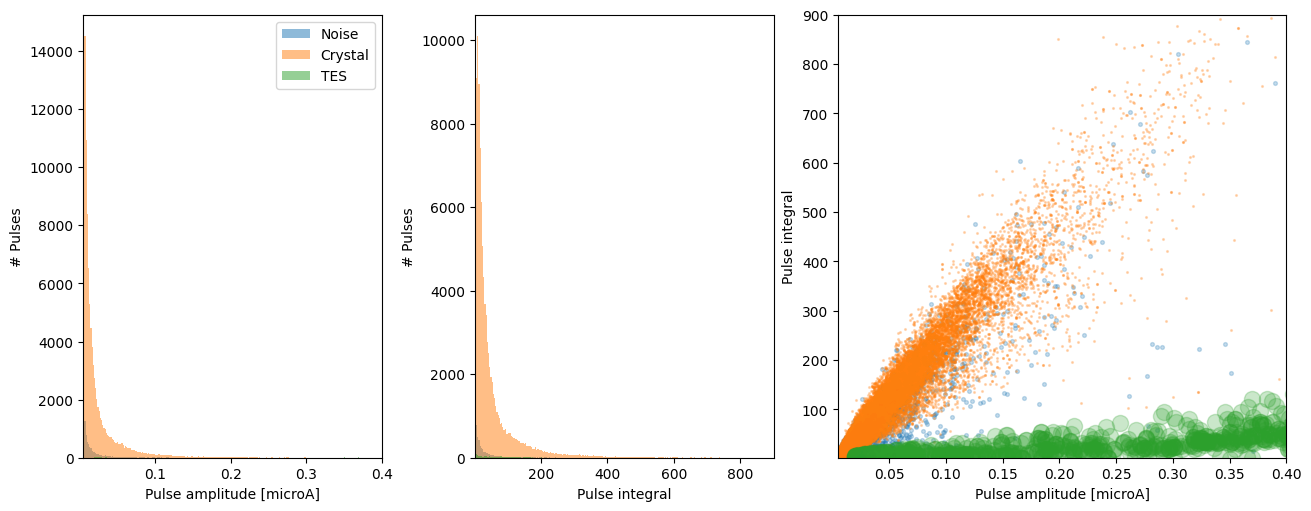

In [15]:
# Zoom in
var1 = {'name': 'Amplitude_CH1',
        'label': 'Pulse amplitude [microA]',
        'range': (0.005,0.4),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'Integral_CH1',
        'label': 'Pulse integral',
        'range': (2,900),
        'bins': 250,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

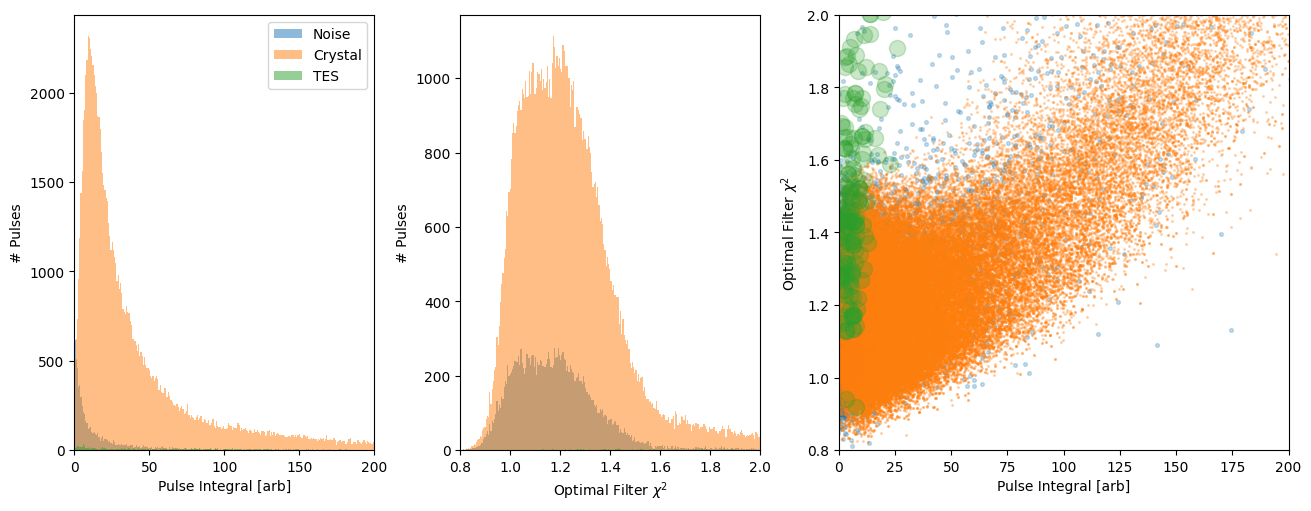

In [16]:
# Chi2
var1 = {'name': 'Integral_CH1',
        'label': 'Pulse Integral [arb]',
        'range': (0,200),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'OF0_chi2_CH1',
        'label': r'Optimal Filter $\chi^2$',
        'range': (0.8,2),
        'bins': 250,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

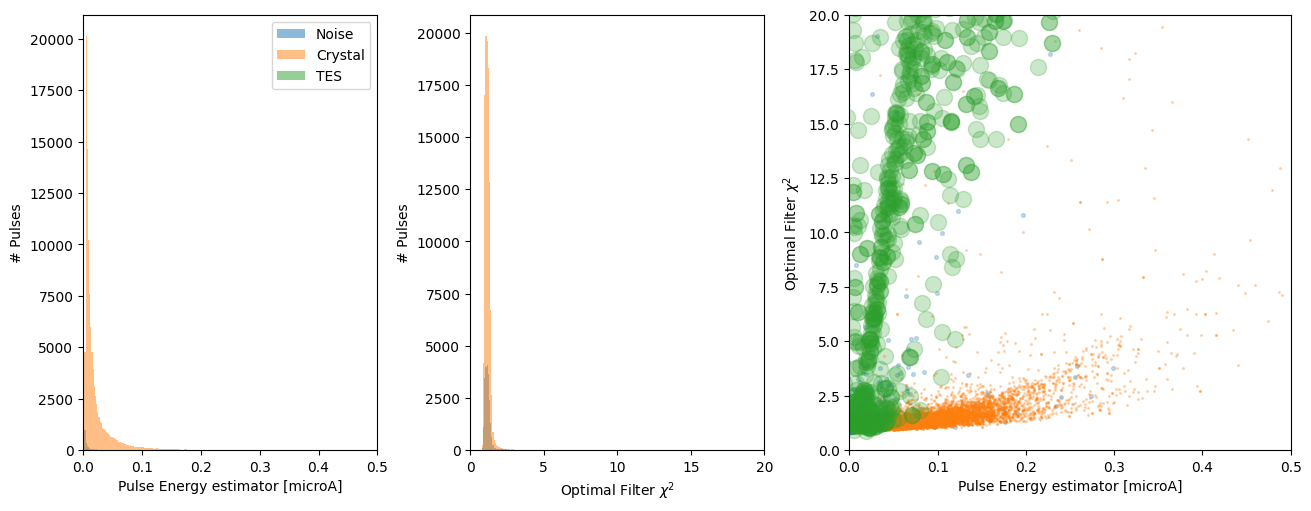

In [17]:
# Chi2
var1 = {'name': 'OFL_CH1',
        'label': 'Pulse Energy estimator [microA]',
        'range': (0.000,0.5),
        'bins': 250,
        'norm':False
       }

var2 = {'name': 'OFL_chi2_CH1',
        'label': r'Optimal Filter $\chi^2$',
        'range': (0,20),
        'bins': 250,
        'norm':False
       }
mask_arr = [mask_noise, mask_crystal, mask_tes] 
mask_labs = ['Noise', 'Crystal', 'TES']
_ = rq_helper.plot_pairs(var1,var2,mask_arr,mask_labs, config_2d_scatter)

### Optimize filters
- The triggering kernel is a gaussian filter which has some parameters
- The smoothing function is a SavGol filter with a sample length and an order.

In [18]:
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

# Savgol parameters
savgol_nsample = [15, 50, 100, 500]
savgol_order = [3]

# Gaussian trigger parameters
# "Gauss,1,1250,4"
gauss_sigmas = np.arange(200,2000,200)
gauss_truncate = 4
gauss_order = 1

n_traces = 20

# Load some config settings
pretrig = config.PRE_TRIG
posttrig = config.POST_TRIG
WindowForPulseRQs = config.WindowForPulseRQs

100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


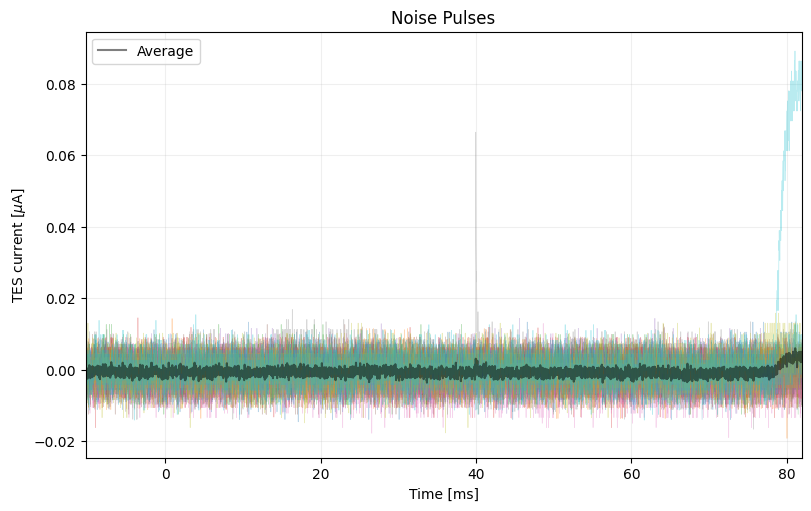

In [19]:
# Load some noise traces:
noise_sample = RQ_helper.sample_from_mask(mask_noise,n_traces)
times, noise_traces = rq_helper.plot_traces(noise_sample, "Noise Pulses", nsmooth=1, plot_data=0.3, plot_mean=0.5,
                                           )

100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


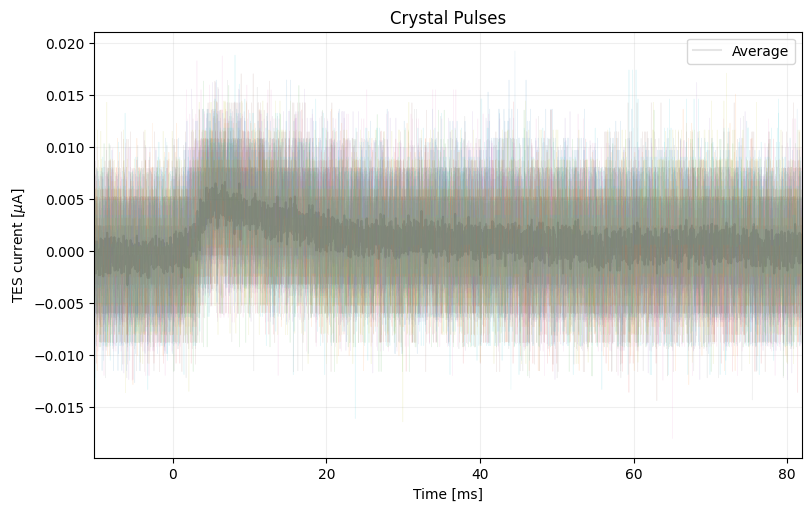

In [20]:
# Load some signal traces with very small amplitude:
crystal_sample = RQ_helper.sample_from_mask(mask_crystal & (RQ_data['OFL_CH1']<0.006),n_traces)
times, signal_traces = rq_helper.plot_traces(crystal_sample, "Crystal Pulses", nsmooth=1, plot_data=0.1, plot_mean=0.1)

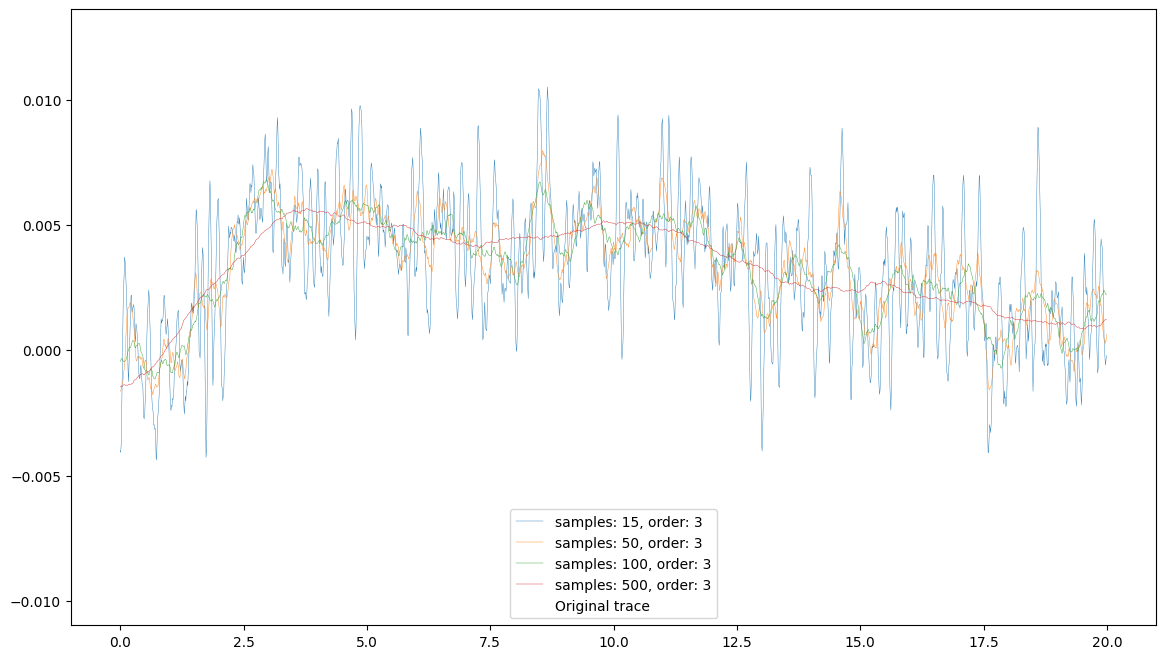

In [21]:
trace = signal_traces.T[0]
sl = np.s_[int(pretrig/8):int(pretrig/8+2*WindowForPulseRQs)]

fig,ax = plt.subplots(figsize=(14,8))
for sg_nsample in savgol_nsample:
    for sg_order in savgol_order:
        filtered_trace = savgol_filter(trace, sg_nsample, sg_order)
        lab = "samples: {}, order: {}".format(sg_nsample,sg_order)
        ax.plot(times[sl], filtered_trace[sl],label=lab, alpha=1, lw=0.3)
        
ax.plot(times[sl], trace[sl], alpha = 0.0, label="Original trace")  
ax.legend()

# From playing around a little, SavGol can be quite large, like 100 is ok! 500 is too large

RiseTime1_ 50 315
RiseTime2_ 15 34
RiseTime3_ 4 6
FallTime1_ 5 413
FallTime2_ 39 41
FallTime3_ 5 11
PulseWidth50_ 63 92
PulseMaxInd_ 626 642


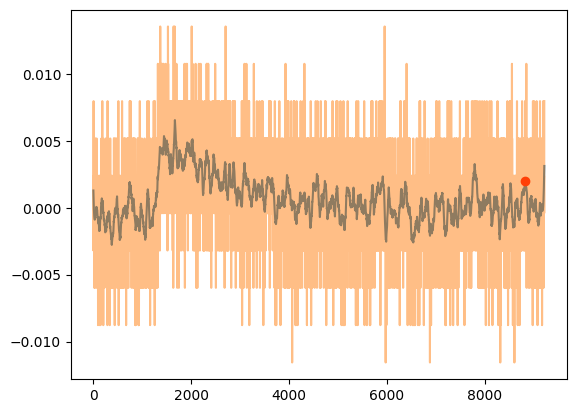

In [22]:
### Investigate Rise and Fall times
# Create a smoothened trace
n_trace = 6
tr_index = np.where(crystal_sample)[0][n_trace]
S = savgol_filter(signal_traces.T[n_trace], 101, 3)

WindowForPulseRQs=1000

# Copied from RQ calculations
tracemax_ind=np.argmax(S[pretrig:pretrig+WindowForPulseRQs])+pretrig
trace_max = np.max(S[pretrig:pretrig+WindowForPulseRQs])

fallingEdge30 = tracemax_ind + np.argmax(S[tracemax_ind:] < (trace_max*0.3)) # This is the falling edge when the pulse drops to 30% of max
fallingEdge50 = tracemax_ind + np.argmax(S[tracemax_ind:] < (trace_max*0.5)) # This is the falling edge when the pulse drops to 50% of max
fallingEdge90 = tracemax_ind + np.argmax(S[tracemax_ind:] < (trace_max*0.9)) # This is the falling edge when the pulse drops to 90% of max

risingEdge30 = tracemax_ind-np.argmax(S[:tracemax_ind][::-1] < (trace_max*0.3)) # This is the rising edge when the pulse drops to 30% of max
risingEdge50 = tracemax_ind-np.argmax(S[:tracemax_ind][::-1] < (trace_max*0.5)) # This is the rising edge when the pulse drops to 50% of max
risingEdge90 = tracemax_ind-np.argmax(S[:tracemax_ind][::-1] < (trace_max*0.9)) # This is the rising edge when the pulse drops to 90% of max

# Printing the results, matched to the PyCRP calculatons. Should be the same?
print("RiseTime1_", risingEdge50-risingEdge30, RQ_data["RiseTime1_CH1"][tr_index])
print("RiseTime2_", risingEdge90-risingEdge50, RQ_data["RiseTime2_CH1"][tr_index])
print("RiseTime3_", tracemax_ind-risingEdge90, RQ_data["RiseTime3_CH1"][tr_index])
print("FallTime1_", fallingEdge30-fallingEdge50, RQ_data["FallTime1_CH1"][tr_index])
print("FallTime2_", fallingEdge50-fallingEdge90, RQ_data["FallTime2_CH1"][tr_index])
print("FallTime3_", -tracemax_ind+fallingEdge90, RQ_data["FallTime3_CH1"][tr_index])
print("PulseWidth50_", (fallingEdge50-risingEdge50), RQ_data["PulseWidth50_CH1"][tr_index])
print("PulseMaxInd_", tracemax_ind-pretrig, RQ_data["PulseMaxInd_CH1"][tr_index])

plt.plot(S)
plt.plot(tracemax_ind, trace_max, marker='o', c='r')
plt.plot(signal_traces.T[n_trace], alpha=0.5)

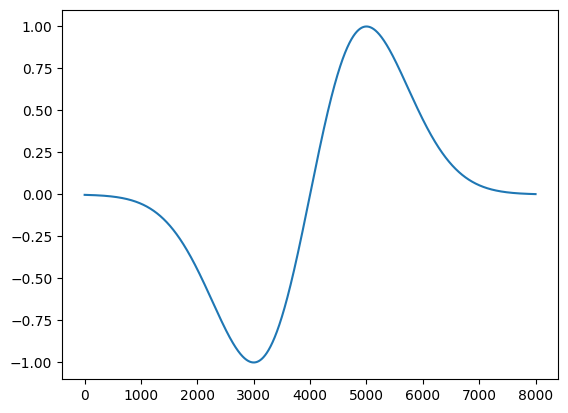

In [23]:
# plot the Gaussian kernel
plt.plot(RQ_data['trig_config']['CH1']['kernel'])

100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


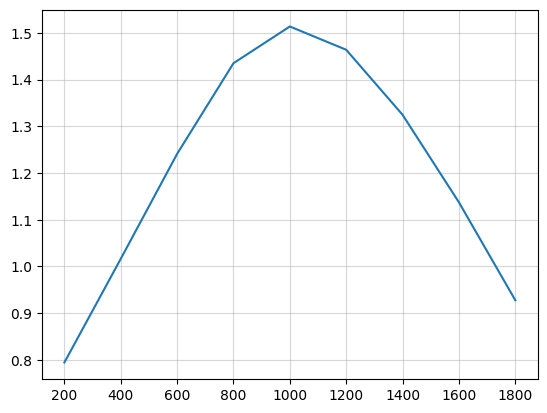

(array([[  0., 179.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  7.,  18.,  25.,  16.,  13.,  23.,  12.,   2.,  23.,  41.]]),
 array([   0. ,  921.5, 1843. , 2764.5, 3686. , 4607.5, 5529. , 6450.5,
        7372. , 8293.5, 9215. ]),
 <a list of 2 BarContainer objects>)

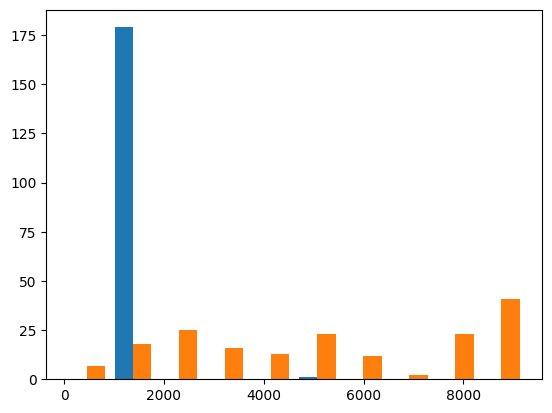

In [24]:
# Gaussian kernel testing
# Found that sigma 1000, order 1, truncate 4 works well
snrs = []
signal_triggers = []
noise_triggers = []

for sigma in tqdm(gauss_sigmas):
    signal = 0
    for signal_tr in signal_traces.T:
        filtered = gaussian_filter(signal_tr, sigma, order=gauss_order, mode='reflect', cval=0.0, truncate=gauss_truncate)
        trig_index = np.argmax(filtered)
        signal_triggers.append(trig_index)
        signal += filtered[trig_index]
        
    noise = 0
    for noise_tr in noise_traces.T:
        filtered = gaussian_filter(noise_tr, sigma, order=gauss_order, mode='reflect', cval=0.0, truncate=gauss_truncate)
        trig_index = np.argmax(filtered)
        noise_triggers.append(trig_index)
        noise += filtered[trig_index]
    snr = signal/noise
    snrs.append(snr)
        
plt.plot(gauss_sigmas,snrs)
plt.grid(alpha=0.5)
plt.show()
plt.hist([signal_triggers, noise_triggers])

### Event viewer

In [28]:
config.__dict__

mappingproxy({'__module__': 'pycrp.processing.configs.config_template',
              'CONFIG_VERSION': 'V1.5',
              'data_type': 'MIT',
              'data_dir': '/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/',
              'data_filename_pattern': '/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/{series}/*.hdf5',
              'block_traces': 20,
              'data_loop_single_file': False,
              'script_io_filename': None,
              'script_rrq_filename': None,
              'USE_WHICH_PSD': 'default',
              'DEFAULT_PSD_FULL_PATH': '',
              'USE_DEFAULT_TEMPLATE': True,
              'USE_WHICH_TEMPLATE': 'analytic 0.3e-3 15e-3',
              'DEFAULT_TEMPLATE_FULL_PATH': '/gpfs/slac/staas/fs1/g/supercdms/users/tomren/notebooks/NR8/processing_result/Template_NR7.joblib',
              'MAKE_TEMPLATE': False,
              'TEMPLATE_MAX_TRACES': 200,
              'res_dir': '/project/def-zqhon

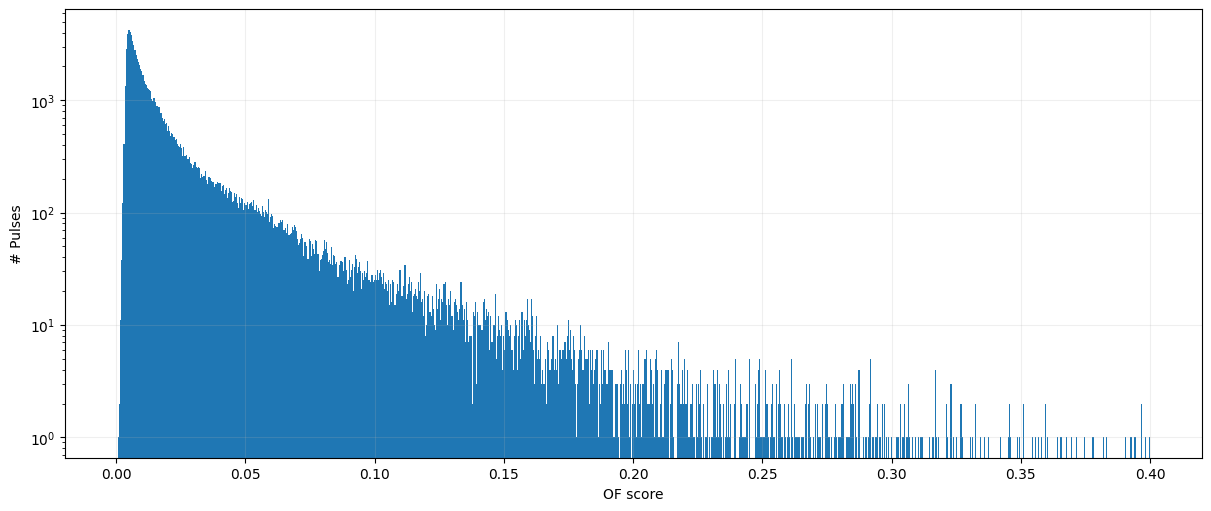

In [32]:
# produce an dictionary for afterwards plotting of different datasets, enable trace collection variables.
export_list = ["trig_ch", "trig_amp", "mask_crystal", "mask_tes","OFL_CH1","Integral_CH1","OFL_chi2_CH1", "trig_fileidx", "trig_traceidx", "trig_loc","MeanBase_CH1", "config_str"]
# Show some crystal pulses of different OFLs:
fix, ax = plt.subplots(figsize=(12,5), constrained_layout=True)
vals, edges, _ = ax.hist(RQ_data["OFL_CH1"][mask_crystal], bins=1000, range = (0,0.4))
ax.set_yscale("log")
ax.grid(alpha=0.2)
ax.set_xlabel("OF score")
ax.set_ylabel("# Pulses")

dump_dict = {key: RQ_data[key] for key in export_list}
dump_dict["series"] = series
joblib.dump(dump_dict,f"{series}.joblib")
del dump_dict

In [ ]:
n_pulses_per_ofl = 30
OFL_ranges = np.reshape(np.percentile(RQ_data["OFL_CH1"][mask_crystal], [1,2,5,6,10,11,30,31,60,61,90,91,97,98]), (-1,2))
OFL_labels = ["1-2%", "5-6%", "10-11%", "30-31%", "60-61%", "90-91%","97-98%"]

dict_export = {}

for OFL_range,OFL_label in zip(OFL_ranges, OFL_labels):
    total_lab = "Crystal Pulses with OF amplitude in "+OFL_label+" [Savgol filter applied]"
    mask_OFL_sample = RQ_helper.sample_from_mask(mask_crystal & (RQ_data["OFL_CH1"]>OFL_range[0]) & (RQ_data["OFL_CH1"]<OFL_range[1]),n_pulses_per_ofl)
    times, traces = rq_helper.plot_traces(mask_OFL_sample, total_lab, plot_data=0, nsmooth=100, plot_mean=0.5)
    dict_export[tuple(OFL_range)]={"traces":traces, "times":times, "indices":mask_OFL_sample, "description":OFL_label}

joblib.dump(dict_export, output_dir+str(datetime.date.today())+series+"_OFL_range_traces.joblib")

: 

In [ ]:
# Plot TES pulses
mask_lab = "TES pulse filter Amp/Int>0.002"
print("Number of TES candidate pulses: ", sum(mask_tes))
mask_amp = RQ_helper.sample_from_mask(mask_tes,50)
times, traces = rq_helper.plot_traces(mask_amp, mask_lab,pre_trig=config.PRE_TRIG,post_trig=config.POST_TRIG)

: 

### Make specific plots

In [ ]:
# Hunt for Fe55 in amplitude and integrals
data_amp = RQ_data['Amplitude_CH1'][mask_crystal]
data_int = RQ_data['Integral_CH1'][mask_crystal]
data_OFL = RQ_data['OFL_CH1'][mask_crystal]

fig, ax = plt.subplots(nrows=3,figsize=(10,7), constrained_layout=True)
ax[0].hist(data_amp, range=(0.001,0.025), bins=350)
ax[0].set_yscale('log')
ax[0].set_xlabel("Amplitude [microA]")
ax[0].set_ylabel("Pulses")
ax[0].set_xlim(0.001,0.025)

ax[1].hist(data_int, range=(0,100), bins=350)
ax[1].set_yscale('log')
ax[1].set_xlabel("Integral [arb]")
ax[1].set_ylabel("Pulses")
ax[1].set_xlim(0,100)

ax[2].hist(data_OFL, range=(0.000,0.04), bins=350)
ax[2].set_yscale('log')
ax[2].set_xlabel("OFL [arb]")
ax[2].set_ylabel("Pulses")
ax[2].set_xlim(0.000,0.04)

fig.savefig("Amplitude_Integral_1D.pdf")

: 

In [ ]:
# Investigate the Rise/Fall times:
samples_per_ms = config.Fs/1e3

fig_rise, ax_rise = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,4))
fig_fall, ax_fall = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,4))

mask_arr = [mask_crystal, mask_tes] 
mask_labs = ['Crystal', 'TES']

for mask, mask_lab in zip(mask_arr,mask_labs):
    _ = ax_rise[0].hist(RQ_data["RiseTime1_CH1"][mask]/samples_per_ms, range=[0,1], bins=50, label=mask_lab, alpha=0.5)
    _ = ax_rise[1].hist(RQ_data["RiseTime2_CH1"][mask]/samples_per_ms, range=[0,5], bins=50, label=mask_lab, alpha=0.5)
    _ = ax_fall[0].hist(RQ_data["FallTime1_CH1"][mask]/samples_per_ms, range=[0,25], bins=100, label=mask_lab, alpha=0.5)
    _ = ax_fall[1].hist(RQ_data["FallTime2_CH1"][mask]/samples_per_ms, range=[0,25], bins=100, label=mask_lab, alpha=0.5)

for ax in [*ax_rise,*ax_fall]:
    #ax.set_yscale('log')
    ax.set_xlabel("ms")
    ax.set_ylabel("# triggered pulses")

ax_rise[0].legend(title="Rise time 30-50%")
ax_rise[1].legend(title="Rise time 50-90%")
ax_fall[0].legend(title="Fall time 30-50%")
ax_fall[1].legend(title="Fall time 50-90%")

: 

In [ ]:
# Exponential tims intervals between triggers:
mask_select = mask_crystal
mask_lab = "Crystal pulse"

duration = trace_len*num_traces_file*num_files/config.Fs
num_peaks = sum(mask_select)

trig_loc_total = (file_loc*num_traces_file+trace_loc)*trace_len+trig_loc_tr
time_diffs = np.diff(trig_loc_total[mask_select])/config.Fs

fig,ax = plt.subplots(ncols=1, figsize=(6.2,3),constrained_layout=True)
n_bins = 100

x_min = 0
x_max = duration/num_peaks*4
width = (x_max/n_bins)
exp_x = np.arange(x_max)
normalisation = width*num_peaks**2/duration

bins, edges = np.histogram(time_diffs, range=(x_min,x_max), bins=n_bins)
edges_mid = (edges[1:]+edges[:-1])/2
ax.errorbar(edges_mid, bins, yerr=np.sqrt(bins), xerr=width/2, fmt='.',label='Data')

# Fit exponential
p = np.polyfit(edges_mid[5:], np.log(bins[5:]), 1)
a = np.exp(p[1])
y_ftited = np.exp(p[1]) * np.exp(p[0] * edges_mid)
ax.plot(edges_mid,y_ftited, label='Exp fit: {:.2f}Hz'.format(abs(p[0])))
        
ax.set_xlabel(r'$\Delta$t [s]')    
ax.set_ylabel('Pulse count')
ax.set_ylim(bottom=0)
ax.set_title('{} rate: Time constant'.format(mask_lab))
ax.legend()

: 

In [ ]:
# Exponential tims intervals between triggers:
mask_select = mask_tes
mask_lab = "TES pulse"

trace_len = config.real_trace_length
trig_loc_tr = RQ_data["trig_loc"]
num_traces_file = max(RQ_data["trig_traceidx"]+1)
trace_loc = RQ_data["trig_traceidx"]
file_loc = RQ_data["trig_fileidx"]
num_files = max(RQ_data["trig_fileidx"]+1)
num_peaks = sum(mask_select)

trig_loc_total = (file_loc*num_traces_file+trace_loc)*trace_len+trig_loc_tr
time_diffs = np.diff(trig_loc_total[mask_select])/config.Fs
duration = trace_len*num_traces_file*num_files/config.Fs

fig,ax = plt.subplots(ncols=1, figsize=(6.2,3),constrained_layout=True)
n_bins = 100

x_min = 0
x_max = duration/num_peaks*4
width = (x_max/n_bins)
exp_x = np.arange(x_max)
normalisation = width*num_peaks**2/duration
exp_y = normalisation*np.exp(-exp_x/(duration/num_peaks)) 
exp_y_min = normalisation*np.exp(-exp_x/(duration/(num_peaks+np.sqrt(num_peaks)))) 
exp_y_max = normalisation*np.exp(-exp_x/(duration/(num_peaks-np.sqrt(num_peaks)))) 

bins, edges = np.histogram(time_diffs, range=(x_min,x_max), bins=n_bins)
edges_mid = (edges[1:]+edges[:-1])/2
ax.errorbar(edges_mid, bins, yerr=np.sqrt(bins), xerr=width/2, fmt='.',label='Data')
ax.plot(exp_x,exp_y, label='Exp fit: ${:.2f}\pm${:.2f}s'.format(duration/num_peaks,
                                                                duration/num_peaks**(3/2)))
ax.fill_between(exp_x,y1=exp_y_min, y2=exp_y_max, color='C1', alpha=0.3)
ax.set_xlabel(r'$\Delta$t [s]')    
ax.set_ylabel('Pulse count')
ax.set_ylim(bottom=0)
ax.set_title('{} rate: Time constant'.format(mask_lab))
ax.legend()

: 

: 